In [2]:
import os
import sys
sys.path.append('./src') 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import yaml

from datasets import build_dataset, build_transforms
from denoiser import get_denoiser
from models import create_vae

import matplotlib.pyplot as plt 
import numpy as np
from tqdm import tqdm

from backbones import get_backbone
from denoiser import get_denoiser, Denoiser

In [798]:
dataset = "mvtec_ad"
category = "zipper"
num_inference_steps = 5
device = 'cuda'
num_samples = 1
start_step = 64

In [799]:
from torch.utils.data import DataLoader
import torch

img_size = 256

normal_dataset = build_dataset(
    dataset_name=dataset,
    data_root = f"data/{dataset}",
    train=False,
    img_size=img_size,
    transform_type="default",
    category = category,
    normal_only = True
)
anom_dataset = build_dataset(
    dataset_name=dataset,
    data_root = f"data/{dataset}",
    train=False,
    img_size=img_size,
    transform_type="default",
    category = category,
    anom_only = True
)
train_dataset = build_dataset(
    dataset_name=dataset,
    data_root = f"data/{dataset}",
    train=True,
    img_size=img_size,
    transform_type="default",
    category = category,
)
print(len(normal_dataset))
print(len(anom_dataset))

32
119


In [800]:
# log_dir = f"./results/ad_unet_vae_ddad/{category}"
# log_dir = f"./results/exp_unet_feature_visa/{category}"
# log_dir = f"./results/exp_unet_feature_ad_256/{category}"
# log_dir = f"./results/exp_unet_feature_ad_wrn/{category}"

# log_dir = f"./results/w2d256ep1000"
log_dir = f"./results/exp_dit_feature_d4w256_lr/{category}"
config_path = os.path.join(log_dir, "config.yaml")
ckpt_path = os.path.join(log_dir, "model_latest.pth")

with open(config_path, 'r') as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

seed = config['meta']['seed']
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed) 

config["diffusion"]["num_sampling_steps"] = str(num_inference_steps)
img_size = config['data']['img_size']
device = device
num_samples = num_samples

mim_in_sh = (272, 16, 16) # for enet
# mim_in_sh = (1792, 16, 16)  # for wrn

img_size = config['data']['img_size']
model: Denoiser = get_denoiser(**config['diffusion'], input_shape=mim_in_sh)
model_ckpt = torch.load(ckpt_path, map_location='cpu', weights_only=True)
results = model.load_state_dict(model_ckpt, strict=False)
print(results)
model.to(device).eval()

<All keys matched successfully>


Denoiser(
  (cls_embed): Embedding(15, 256)
  (net): DiT(
    (x_embedder): PatchEmbed(
      (proj): Conv2d(272, 256, kernel_size=(1, 1), stride=(1, 1))
      (norm): Identity()
    )
    (x_embedder_linear): Linear(in_features=272, out_features=256, bias=True)
    (z_embedder): ConditionEmbedder(
      (mlp): Sequential(
        (0): Linear(in_features=16, out_features=256, bias=True)
        (1): SiLU()
        (2): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (t_embedder): TimestepEmbedder(
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): SiLU()
        (2): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (y_embedder): LabelEmbedder(
      (embedding_table): Embedding(15, 256)
    )
    (blocks): ModuleList(
      (0-3): 4 x DiTBlock(
        (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=False)
        (attn): Attention(
          (qkv): Linear(in_features=256, out_fea

In [801]:
# model_kwargs = {
#     'model_type': 'efficientnet-b4',
#     'outblocks': (1, 5, 9, 21),
#     'outstrides': (2, 4, 8, 16),
#     'pretrained': True,
#     'stride': 16
# }
# # model_kwargs = {
# #     'model_type': 'wide_resnet50_2',
# # }
# print(f"Using feature space reconstruction with {model_kwargs['model_type']} backbone")
# feature_extractor = get_backbone(**model_kwargs)
# feature_extractor.to(device).eval()

In [802]:
bs = 8
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4, drop_last=False)
normal_dataloader = DataLoader(normal_dataset, batch_size=bs, shuffle=False, num_workers=4, drop_last=False)
anom_dataloader = DataLoader(anom_dataset, batch_size=bs, shuffle=False, num_workers=4, drop_last=False)

start_t = torch.tensor([0] * bs, device=device, dtype=torch.long)
end_t = torch.tensor([num_inference_steps] * bs, device=device, dtype=torch.long)

In [803]:
# Compute global stats for training data
features = []
for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
    img = data["samples"].to(device)
    with torch.no_grad():
        x, _ = feature_extractor(img)
        features.append(x)
features = torch.cat(features, dim=0)   # (N, c, h, w)
avg_glo = features.mean(dim=(0, 2, 3))  # (c, )
std_glo = features.std(dim=(0, 2, 3))  # (c, )

100%|██████████| 30/30 [00:01<00:00, 21.61it/s]


In [804]:
def calculate_log_pdf(x):
    ll = -0.5 * (x ** 2 + np.log(2 * np.pi))
    ll = ll.sum(dim=(1, 2, 3))
    return ll

import time

normal_lls = []
lts = []
for batch in tqdm(normal_dataloader):
    images = batch["samples"].to(device)
    labels = batch["clslabels"].to(device)
    
    s_t = time.time()
    with torch.no_grad():
        latents_org, _ = feature_extractor(images)
        latents_org = (latents_org - avg_glo.view(1, -1, 1, 1)) / (std_glo.view(1, -1, 1, 1) + 1e-6)
        latents_last = model.ddim_reverse_sample(
            latents_org, start_t, labels, eta=0.0
        )
        # latents_last = latents_org
    e_t = time.time()
    lts.append(e_t - s_t)
    ll = calculate_log_pdf(latents_last.cpu())
    normal_lls.extend(ll)

print(f"Average Latency: {np.mean(lts)}[s] for batch size {bs}")

100%|██████████| 4/4 [00:01<00:00,  3.94it/s]

Average Latency: 0.04277151823043823[s] for batch size 8


In [805]:
anom_lls = []
for batch in tqdm(anom_dataloader):
    images = batch["samples"].to(device)
    labels = batch["clslabels"].to(device)
    
    with torch.no_grad():
        latents_org, _ = feature_extractor(images)
        latents_org = (latents_org - avg_glo.view(1, -1, 1, 1)) / (std_glo.view(1, -1, 1, 1) + 1e-6)
        latents_last = model.ddim_reverse_sample(
            latents_org, start_t, labels, eta=0.0
        )
        # latents_last = latents_org
    
    ll = calculate_log_pdf(latents_last.cpu())
    anom_lls.extend(ll)

100%|██████████| 15/15 [00:01<00:00,  8.13it/s]


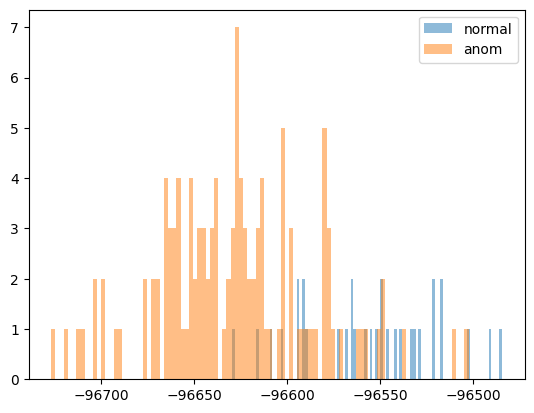

In [806]:
plt.hist(normal_lls, bins=100, alpha=0.5, label="normal")
plt.hist(anom_lls, bins=100, alpha=0.5, label="anom")
plt.legend()
plt.show()

In [807]:
from sklearn.metrics import roc_curve, roc_auc_score
normal_lls = np.array(normal_lls) * -1
anom_lls = np.array(anom_lls) * -1
y_true = np.concatenate([np.zeros(len(normal_lls)), np.ones(len(anom_lls))])
y_score = np.concatenate([normal_lls, anom_lls])
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = roc_auc_score(y_true, y_score)

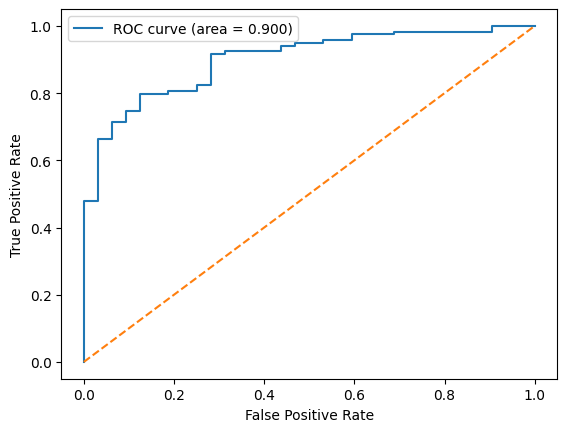

: 

In [ ]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.3f})")
ax.plot([0, 1], [0, 1], linestyle="--")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()
plt.show()